In [118]:
import sys
sys.path.append('..')
from db1 import *

R = PolynomialRing(QQ, 't')
S = PolynomialRing(ZZ, 't')
t = R.gen()

def is_paving(M):
    n = M.size()
    r = M.rank()
    return (len(M.independent_r_sets(r-1)) == binomial(n, r-1))

def q_kl(k, h):
    return kazhdan_lusztig_inverse_uniform(k, h+1) - kazhdan_lusztig_inverse_uniform(k-1, h)

def kl_inverse_fast(M):
    if M.loops(): return R(0)
    k, n = M.rank(), M.size()
    if k == n or k == 0: return R(1)
    if not M.is_connected():
        ans = R(1)
        CC = M.components()
        for N in CC:
            res = M.delete(M.groundset() - N)
            ans = ans * kl_inverse_fast(res)
        return ans

    if is_paving(M):
        return kl_inverse_paving(M)
    if is_paving(M.dual()):
        return kl_inverse_copaving(M)
    """
    if n <= 8 and M.is_connected():
        for i in range(len(mat[n][k])):
            if mat[n][k][i].is_isomorphic(M):
                return ikl[n][k][i]
    """
    LF = M.lattice_of_flats()
    ans = R(0)
    for F in LF:
        if len(F) != n:
            Res = M.delete(M.groundset() - F)
            Con = M.contract(F)
            chi = characteristic_polynomial(Con)(1/t) * t**(Con.rank())
            PPP = kl_inverse_fast(Res)(t) * (-1)**(Res.rank())
            ans = ans + chi * PPP
    assert (t**k * ans(1/t)).numerator() == -ans(t)
    ans = ans.numerator() * (-1)**(k+1)
    return ans.truncate((k+1)//2)

def kazhdan_lusztig_inverse_uniform(k, n):
    if k == n:
        return R(1)
    d = k
    m = n - d
    ans = 0
    for j in range((d-1)//2 + 1):
        ans = ans + m * (d-2*j)/((m+j) * (m+d-j)) * binomial(d, j) * t**j
    return ans * binomial(m+d, d)

def kl_inverse_paving(M):
    assert is_paving(M)
    n = M.size()
    k = M.rank()
    ans = kazhdan_lusztig_inverse_uniform(k, n)
    for H in M.hyperplanes():
        h = len(H)
        if h >= k:
            ans = ans - q_kl(k, h)
    return ans

def kl_inverse_copaving(M):
    assert is_paving(M.dual())
    n = M.size()
    k = M.rank()
    ans = kazhdan_lusztig_inverse_uniform(k, n)
    for H in M.dual().hyperplanes():
        h = len(H)
        if h >= n-k:
            ans = ans - kli_vtilde_dual(n-k, h, n) + kazhdan_lusztig_inverse_uniform(h-n+k+1, h) * kazhdan_lusztig_inverse_uniform(n-h-1, n-h)
    return ans

def kli_vtilde_dual(k, h, n):
    return helper1(n-k, h, n)

def helper1(k, h, n):
    c = n - h
    ans1 = kazhdan_lusztig_inverse_uniform(k, n)
    ans2 = helper2(c, k, n)
    ans3 = kazhdan_lusztig_inverse_uniform(k-c+1, h) * kazhdan_lusztig_inverse_uniform(c-1, c)
    return ans1 - ans2 + ans3

def helper2(c, k, n):
    h = n - c
    ans = 0
    for j in range(k-c+1):
        ans = ans + binomial(n-c, j) * (-1)**(c-1+j) * kazhdan_lusztig_inverse_uniform(c-1, c) * t**(k-c-j+1) * chuly(k-c-j+1, n-c-j)(1/t)
    for i in range(c-1):
        for j in range(k-i):
            ans = ans + binomial(c, i) * binomial(n-c, j) * (-1)**(i+j) * t**(k-i-j) * helper4(c, k, n, i, j)(1/t)
    ans = ans.numerator().truncate((k-1)//2 + 1)
    if ans[0] < 0:
        ans = -ans
    return ans

def helper3(c, k, n):
    ans = 0
    for j in range(k-c+1):
        ans = ans + binomial(n-c, j) * uniformKLpoly(c-1, c) * (-1)**(k-c-j+1) * kazhdan_lusztig_inverse_uniform(k-c-j+1, n-c-j)
    for i in range(c-1):
        for j in range(k-i):
            ans = ans + binomial(c, i) * binomial(n-c, j) * (-1)**(k-i-j) * helper2(c-i, k-i-j, n-i-j)
    return -ans

def helper4(c, k, n, i, j):
    ans = 0
    for l in range(c-i-1):
        ans = ans + (-1)**l * (t-1)**(max(n-i-j-l-1, 0))
    for u in range(n-k-1):
        ans = doit_once(ans)
    return ans

def chuly(a, b):
    ans = (t-1)**b
    for i in range(b-a):
        ans = doit_once(ans)
    return ans

def doit_once(p):
    p = p // t**2
    p = p * t
    p = p - p(1)
    return p

def lorenzo(k, h, n):
    c = n - h
    ans1 = uniformKLpoly(k, n) + uniformKLpoly(k-c+1, h) * uniformKLpoly(c-1, c)
    ans2 = helper3(c, k, n)
    return ans1 - ans2

In [119]:
invkl = kl_inverse_fast

def kl(M):
    return M.lattice_of_flats().kazhdan_lusztig_polynomial()(t)

def sum_prqc(M, S, b):
    return sum((-1) ^ (b * M.rank(F)) * kl(M.delete(M.groundset() - set(F))) * \
            (-1) ^ ((1 - b) * M.contract(F).rank()) * invkl(M.contract(F)) for F in S)

def sum_pcqr(M, S, b):
    return sum((-1) ^ (b * M.rank(F)) * invkl(M.delete(M.groundset() - set(F))) * \
            (-1) ^ ((1 - b) * M.contract(F).rank()) * kl(M.contract(F)) for F in S)

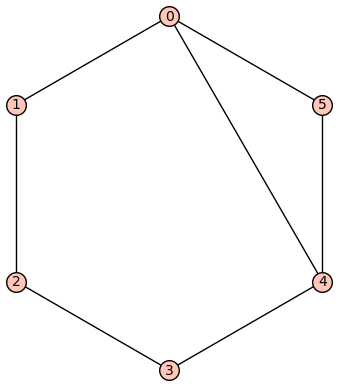

5

In [120]:
def setS(L, e):
    return [x for x in L if not set(e).issubset(set(x)) and set(x).union(set(e)) in L]

def parallel_connection(m, n):
    G = graphs.CycleGraph(m + n - 2)
    G.add_edge(0, m-1)
    edge_e = frozenset({(0, m - 1)})
    return G, edge_e

G, e = parallel_connection(5, 3)
G.show()
M = Matroid(G)
L = list(M.lattice_of_flats())
M.rank()

In [121]:
[kl(M), invkl(M), sum_prqc(M, L[1:], 0), sum_pcqr(M, L[1:], 1)]

[3*t^2 + 8*t + 1, 3*t^2 + 11*t + 8, 3*t^2 + 11*t + 8, -3*t^2 - 8*t - 1]

In [122]:
def qhat(M):
    return (-1) ^ M.rank() * invkl(M)

def sum_prhc(M, S):
    return sum(kl(M.delete(M.groundset() - set(F))) * \
            qhat(M.contract(F)) for F in S)

def sum_pchr(M, S):
    return sum(qhat(M.delete(M.groundset() - set(F))) * \
            kl(M.contract(F)) for F in S)

[kl(M), qhat(M), sum_prhc(M, L[1:-1]), sum_pchr(M, L[1:-1])]

[3*t^2 + 8*t + 1, -3*t^2 - 11*t - 8, 3*t + 7, 3*t + 7]